In [1]:
import tensorflow as tf

autoencoder_path = './gaussian_denoisor_with_cnn.h5'
autoencoder = tf.keras.models.load_model(autoencoder_path)

autoencoder.trainable = False
autoencoder.summary()

W0908 19:37:09.347476 140520542365504 deprecation.py:506] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0908 19:37:09.348099 140520542365504 deprecation.py:506] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0908 19:37:09.348687 140520542365504 deprecation.py:506] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/ops

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_maxpooling1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 14, 14, 32)        9248      
_________________________________________________________________
encoder_maxpooling2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
decoder_conv1 (Conv2D)       (None, 7, 7, 32)          9248      
_________________________________________________________________
decoder_upsampling1 (UpSampl (None, 14, 14, 32)        0         
_________________________________________________________________
decoder_conv2 (Conv2D)       (None, 14, 14, 32)        9

In [2]:
encoder_outputs = autoencoder.get_layer('encoder_maxpooling2').output

outputs = tf.keras.layers.Dropout(0.25)(encoder_outputs)
outputs = tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(3,3),
                                 padding='same',
                                 activation='elu',
                                 name='classifier_conv1')(outputs)
outputs = tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(3,3),
                                 padding='same',
                                 activation='elu',
                                 name='classifier_conv2')(outputs)
outputs = tf.keras.layers.Dropout(0.25)(outputs)
outputs = tf.keras.layers.Flatten()(outputs)
outputs = tf.keras.layers.Dense(256, activation='elu')(outputs)
outputs = tf.keras.layers.Dropout(0.5)(outputs)
outputs = tf.keras.layers.Dense(10, activation='softmax')(outputs)

digit_classifier = tf.keras.Model(inputs=autoencoder.input,
                                  outputs=outputs)
digit_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv1_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_maxpooling1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 14, 14, 32)        9248      
_________________________________________________________________
encoder_maxpooling2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
classifier_conv1 (Conv2D)    (None, 7, 7, 64)          18496 

In [3]:
digit_classifier.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler

height, width, n_channels = (28, 28, 1)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(len(y_train), -1).astype(np.float32)
X_test = X_test.reshape(len(y_test), -1).astype(np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).reshape(-1, height, width, n_channels)
X_test = scaler.transform(X_test).reshape(-1, height, width, n_channels)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
X_train_partial = X_train[:5000]
y_train_partial = y_train[:5000]
X_valid = X_train[5000:7500]
y_valid = y_train[5000:7500]

n_epochs = 50
batch_size = 256

model_path = './transfer_learning_with_autoencoder.h5'
model_saver = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=0, save_best_only=True)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0)

history = digit_classifier.fit(X_train_partial, y_train_partial,
                               epochs=n_epochs, batch_size=batch_size,
                               shuffle=True, validation_data=(X_valid, y_valid),
                               callbacks=[model_saver, early_stopper])

Train on 5000 samples, validate on 2500 samples
Epoch 1/50
5000/5000 [==============================] - 2s 352us/sample - loss: 1.0812 - acc: 0.6902 - val_loss: 0.3768 - val_acc: 0.8868
Epoch 2/50
5000/5000 [==============================] - 0s 70us/sample - loss: 0.4032 - acc: 0.8820 - val_loss: 0.2643 - val_acc: 0.9152
Epoch 3/50
5000/5000 [==============================] - 0s 73us/sample - loss: 0.2990 - acc: 0.9064 - val_loss: 0.2202 - val_acc: 0.9344
Epoch 4/50
5000/5000 [==============================] - 0s 75us/sample - loss: 0.2490 - acc: 0.9216 - val_loss: 0.1976 - val_acc: 0.9372
Epoch 5/50
5000/5000 [==============================] - 0s 66us/sample - loss: 0.2063 - acc: 0.9336 - val_loss: 0.1973 - val_acc: 0.9356
Epoch 6/50
5000/5000 [==============================] - 0s 66us/sample - loss: 0.1854 - acc: 0.9406 - val_loss: 0.1798 - val_acc: 0.9404
Epoch 7/50
5000/5000 [==============================] - 0s 66us/sample - loss: 0.1695 - acc: 0.9482 - val_loss: 0.1635 - val_acc:

In [6]:
test_loss, test_acc = digit_classifier.evaluate(X_test, y_test, batch_size=256)
print('test loss: {:1.5f}, test acc: {:1.5f}'.format(test_loss, test_acc))

10000/10000 [==============================] - 0s 28us/sample - loss: 0.1257 - acc: 0.9690
test loss: 0.12569, test acc: 0.96900


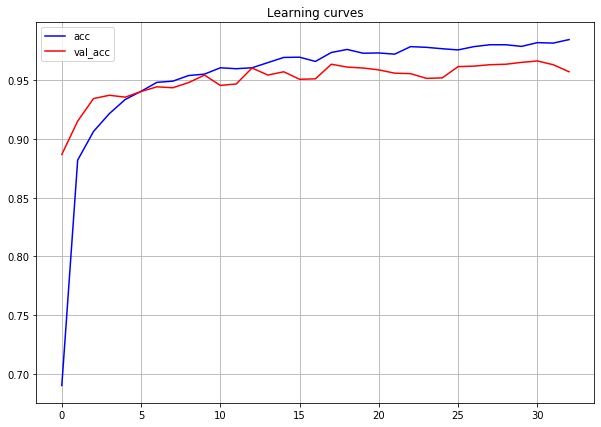

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.title('Learning curves')
plt.plot(history.history['acc'], 'b', label='acc')
plt.plot(history.history['val_acc'], 'r', label='val_acc')
plt.legend()
plt.grid()
plt.show()